In [92]:
%pip install --upgrade pip
%pip install pandas numpy openpyxl matplotlib seaborn xlsxwriter
import pandas,numpy,os,re,datetime,random,itertools
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Paramètres

In [93]:
PERIODE = [2010,2020]

# Chargement des données

In [94]:
def get_indice_name(file_name:str)->str:
    """Cette fonction permet d'obtenir le nom de l'indice 
    à partir du code de ce dernier
    """
    # Nous définissons les détails de chaque indice 
    # dans une liste de dictionnaires
    # Avec les clés : code et name
    indices = [
            {'code':'^FCHI','name':'CAC40'},
            {'code':'^GSPC','name':'S&P 500'},
            {'code':'^HSI','name':'Hang Seng'},
            {'code':'MSCI','name':'MSCI Emerging Markets'},
            {'code':'^BVSP','name':'Sao Paolo'},
            {'code':'^MOEX','name':'Moscow'},
            {'code':'BSE','name':'Bombay'},
            {'code':'TWII','name':'Taiwan'},
            {'code':'Shanghai','name':'Shanghai'},
            ]
    
    # Nous parcourons la liste pour trouver 
    # le dictionnaire correspondant
    # à l'indice dont le code correspond à file_name (paramètre)
    for indice in indices:
        if indice['code'] in file_name:
            # Nous renvoyons le nom de l'indice correspondant
            # Lorsqu'il est trouvé dans la liste
            return indice['name']
    # Sinon nous renvoyons le file_name (paramètre)
    return file_name 


def load_data(directory:str)->dict:
    # Nous définissons un dictionnaire
    data = dict()
    # Nous lisons tous les fichiers présents dans le directory (paramètre)
    for file_path in os.listdir(directory):
        try:
            # Si MSCI alors le fichier est différent (séparateur ;)
            if "MSCI" in file_path or "Shanghai" in file_path:
                # Nous lisons le fichier dans un dataframe
                # En utilisant le séparateur ;
                df = pandas.read_csv(f'{directory}/{file_path}', sep=';') 
            else:
                # Nous lisons le fichier dans un dataframe
                # Avec les paramètres par défaut
                df = pandas.read_csv(f'{directory}/{file_path}')
            # Nous ajoutons le dataframe dans le dictionnaire
            data[get_indice_name(file_path)] = df
        except Exception as error:
            # S'il y a une erreur, nous affichons le message
            # Mais nous ne levons pas d'exception
            # Ceci permet de continuer le chargement
            print(file_path,error)
    # Nous renvoyons le dictionnaire avec toutes les données
    return data

In [95]:
data = load_data('./input')

.DS_Store 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte


In [96]:
print(data)

{'Hang Seng':             Date          Open          High           Low         Close  \
0     1986-12-31   2568.300049   2568.300049   2568.300049   2568.300049   
1     1987-01-01           NaN           NaN           NaN           NaN   
2     1987-01-02   2540.100098   2540.100098   2540.100098   2540.100098   
3     1987-01-05   2552.399902   2552.399902   2552.399902   2552.399902   
4     1987-01-06   2583.899902   2583.899902   2583.899902   2583.899902   
...          ...           ...           ...           ...           ...   
9234  2023-05-19  19535.490234  19610.720703  19352.810547  19450.570313   
9235  2023-05-22  19479.060547  19806.439453  19410.070313  19678.169922   
9236  2023-05-23  19713.460938  19769.140625  19363.500000  19431.250000   
9237  2023-05-24  19279.390625  19304.199219  19046.800781  19115.929688   
9238  2023-05-25  18930.230469  18930.230469  18620.839844  18746.919922   

         Adj Close        Volume  
0      2568.300049  0.000000e+00  
1  

# Traitement des données

In [97]:
def clean_data(data:dict)->dict:
    # Nous définissons un nouveau dictionnaire
    new_dict = dict()
    # Nous parcourons les données
    for header,content in data.items():
        # Nous appliquonns le type DataFrame
        # au contenu, afin de prévenir les erreurs
        content = pandas.DataFrame(content)
        # Nous vérifions le format du champ date
        if re.match("^\d{2}/\d{2}/\d{2}$",content.Date[0]):
            # Nous transformons le champ mm/dd/yy en yyyy-mm-dd
            content.Date = content.Date.apply(
                lambda x: pandas.to_datetime(x, format='%m/%d/%y').strftime('%Y-%m-%d')
            )
        elif re.match("^\d{2}/\d{2}/\d{4}$",content.Date[0]):
            # Nous transformons le champ mm/dd/yyyy en yyyy-mm-dd
            content.Date = content.Date.apply(
                lambda x: pandas.to_datetime(x, format='%m/%d/%Y').strftime('%Y-%m-%d')
            )

        for column_name in content.columns:
            # Si le nom de la colonne comporte Close ou Date
            if column_name.strip().upper() in ['CLOSE','DATE']:
                # Si la colonne est date
                if column_name.strip().upper() in ['DATE']:
                    # Nous trions les dates par ordre croissant
                    content = content.sort_values(column_name, ascending=True)
                    # Nous ajoutons en indices la colonne date
                    content = content.set_index(column_name)
                    # Nous convertissons le type en datetime
                    content.index = pandas.to_datetime(content.index)
                else:
                    # Nous enregistrons le nom de la colonne close
                    close_column = [column_name]
        

        # Nous gardons uniquement la colonne close
        content = content.loc[:, close_column]

    
        # Nous supprimons les lignes vides
        content = content.dropna()

        new_dict[header] = content
    return new_dict

In [98]:
cleaned_data = clean_data(data)

# Calcul des statistiques

In [99]:
def statistics(cleaned_data:dict)->dict:
    # Nous allons calculer le rendement annuel
    # prix de clôture du dernier jour de l'année divisé par
    # prix de clôture du premier jour de l'année)
    results = pandas.DataFrame()
    for header,df in cleaned_data.items():
        stats = pandas.DataFrame({'Rendement Annuel':[]})
        first = True
        for index, row in df.iterrows():
            if first:
                first_day_price = row[0]
                week = index.week
                first = False
            # Si l'année change
            if index.week != week:
                # Nous calculons le rendement annuel
                stats.loc[index] = [(last_day_price/first_day_price)-1]
                first_day_price = row[0]
                week = index.week
            last_day_price = row[0]    
        results[header] = stats
        results = results.dropna()
    return results

In [100]:
statistics = statistics(cleaned_data)

# Construction des portefeuilles

In [101]:
def generate_weights(indexes_number):
    # Define the number of indexes and the step value
    num_indexes = indexes_number
    step = 0.05

    # Define the range of percentages to generate
    min_percent = 0
    max_percent = 1
    percent_range = range(int(min_percent/step), int(max_percent/step) + 1)

    # Generate all combinations of percentages using itertools.product()
    weight_combinations = itertools.product(percent_range, repeat=num_indexes)

    return [list(round(w*step,2) for w in weights) for weights in weight_combinations if sum(weights)*step == 1.0]


In [102]:
statistics.to_excel('output.xlsx')

In [103]:
# Create portfolios composed of 3 indexes (always 2 developed markets)

def portfolio_creation(merged_df):
    # Initialize excel writer to draw charts later
    writer = pandas.ExcelWriter(f'./results/portfolios.xlsx', engine='xlsxwriter')
    # Create a workbook and worksheet object from the writer
    workbook = writer.book
    # keep only rows with index between PERIODE
    merged_df = statistics[merged_df.index.year >= PERIODE[0]]
    merged_df = merged_df[merged_df.index.year <= PERIODE[1]]
    # Calculate the correlation matrix
    corr_matrix = merged_df[merged_df.columns].corr()
    # Create a heatmap of the correlation matrix
    sns.heatmap(corr_matrix, cmap='gray', annot=True)
    # Save the heatmap to file
    plt.savefig('heatmap.png')
    
    developed_market = merged_df[["CAC40","S&P 500"]]
    print(merged_df.info())
    # Remove two columns from the DataFrame
    merged_df = merged_df.drop(["CAC40","S&P 500"], axis=1)
    weights_list = generate_weights(3)

    for emerging_market in merged_df.columns:
        # Create a storage df
        portfolios_df = pandas.DataFrame()
        details = pandas.DataFrame()
        analyzed_portfolio = developed_market.copy()
        analyzed_portfolio[emerging_market] = merged_df[emerging_market]

        for i,weights in enumerate(weights_list):
            # TO calculate the return of the portfolio,
            # we can use the weight
            # but to calculate the risk, we have to use covariance matrix
            returns = numpy.array([analyzed_portfolio[mean_column] for mean_column in analyzed_portfolio.columns])
            cov_matrix = numpy.cov(returns)
            # Portfolio standard deviation
            portfolio_std = numpy.sqrt(numpy.dot(numpy.dot(weights, cov_matrix), weights))
            # Calculate portfolio return
            portfolio_return = numpy.mean(numpy.dot(returns.T, weights))
            composition = str()
            portfolio_df = pandas.DataFrame({
                'risks':portfolio_std,
                'returns':portfolio_return,
                },index=[i])
            for weight,title in zip(weights,analyzed_portfolio.columns):
                portfolio_df[title]=f"{round(weight*100)}%"
                composition += f"{title} : {round(weight*100)}%\n"
                if weight == 1.0:
                    detail = pandas.DataFrame(
                        {
                            'risks':portfolio_std,
                            'returns':portfolio_return,
                        },
                        index=[i]
                    )
                    detail["Étiquette"] = f"{title} : {round(weight*100)}%"
                    details = pandas.concat([details,detail])

            portfolios_df = pandas.concat([portfolios_df,portfolio_df])
        
        portfolios_df = portfolios_df.sort_values(emerging_market)
        portfolios_df.to_excel(writer,sheet_name=emerging_market,index=False)
        # Get the workbook and worksheet objects from the writer
        worksheet = writer.sheets[emerging_market]

        # Define the format for the first two columns
        percentage_format = workbook.add_format({'num_format': '0.00%'})
        worksheet.set_column('A:B', None, percentage_format)

        # Get the index label of the portfolio with the lowest risk
        min_risk_portfolio = portfolios_df['risks'].idxmin()
        min_risk_portfolio = portfolios_df.loc[[min_risk_portfolio]]
        headers = min_risk_portfolio.drop(['risks', 'returns'], axis=1).columns
        values =  min_risk_portfolio.drop(['risks', 'returns'], axis=1).values.tolist()[0]
        etiquette = str()
        for header,value in zip(headers,values):
            etiquette += f"{header} : {value}\n"
        min_risk_portfolio["Étiquette"] = etiquette.rstrip("\n")
        min_risk_portfolio = min_risk_portfolio.drop(headers, axis=1)
        details = pandas.concat([details,min_risk_portfolio])
        details.to_excel(writer,sheet_name=f"{emerging_market}_extremes",index=False)
    writer.close()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 447 entries, 2010-01-04 to 2020-12-28
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Hang Seng  447 non-null    float64
 1   CAC40      447 non-null    float64
 2   S&P 500    447 non-null    float64
 3   Sao Paolo  447 non-null    float64
 4   Taiwan     447 non-null    float64
dtypes: float64(5)
memory usage: 21.0 KB
None


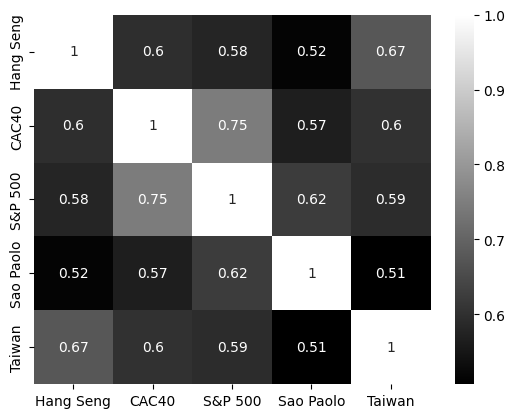

In [104]:
portfolio_creation(statistics)

# Calcul de la matrice de corrélation

# find the index of the row with the lowest risk for each return group
min_risk_idx = portfolios_df.groupby('returns')['risks'].idxmin()

# filter the dataframe to keep only the rows with the lowest risk for each return group
df = portfolios_df.loc[min_risk_idx]

# order the dataframe by "return"
df = df.sort_values(by='returns')

# filter out rows where the "risk" column is not in ascending order as well
df = df[df['risks'].diff().fillna(0) >= 0]


# reset the index of the dataframe
df = df.reset_index(drop=True)

df.to_excel(writer,sheet_name="cleaned",index=False)